# OSM Econ Week 6: Kyle Model
## Rebekah Dix

In [3]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint as pprint
import pickle
import scipy.stats as sts

In [4]:
# Import data
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open('data/' + file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

### Define a class that represents a single orderbook.

In [91]:
class OrderBook:
    """
    This class represents an orderbook. 
    
    Attributes:
        data (dict) : raw data
        time (scalar) : time (in seconds since midnight) of observations
        df (dataframe) : dataframe with price and quantity observations
        P (vector) : vector of prices (with extreme values discarded)
        Q (vector) : vector of quantities (with extreme values discarded)
        midpoint (scalar) : Actual midpoint of the BBO
        gamma (scalar) : intercept of y = gamma + beta * P regression
        beta (scalar) : slope of y = gamma + beta * P regression
        p (scalar) : market clearing price
        ratio (scalar) : noise signal ratio
        
    """
    
    def __init__(self, data, lower, upper):
        self.data = data[1]
        self.time = data[0]
        self.lower = lower
        self.upper = upper
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        df.columns = ['Quantity', 'Type', 'na','naa']
        df = df.drop(['na', 'naa'], axis = 1)
        
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        orders = pd.concat([self.demand, self.supply], sort=True)
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        # Restrict attention to range around equilibrium price
        self.orders = orders[(orders.index > lower * self.midpoint) 
                             & (orders.index < upper * self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def estimate(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.p = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot_orderbook(self):
#         fig = plt.figure(figsize=(10,7))
#         plt.plot(self.P, self.Q)
#         plt.xlabel('Price')
#         plt.ylabel('Quantity')
#         plt.legend()
#         plt.show()

        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='Quantity Demanded')
        plt.plot(self.supply.index.values, self.supply['QS'], label='Quantity Supplied')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'r', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated p_0 is: %f" %self.p)
        print("The actual midpoint of the BBO is: %f" %self.midpoint)
        

### Plot orderbooks and estimated equations

In [107]:
def show_orderbook(file_obj, t):
    test = OrderBook(file_obj[t], .9, 1.1)
    test.estimate()
    test.plot_orderbook()
    test.compare()

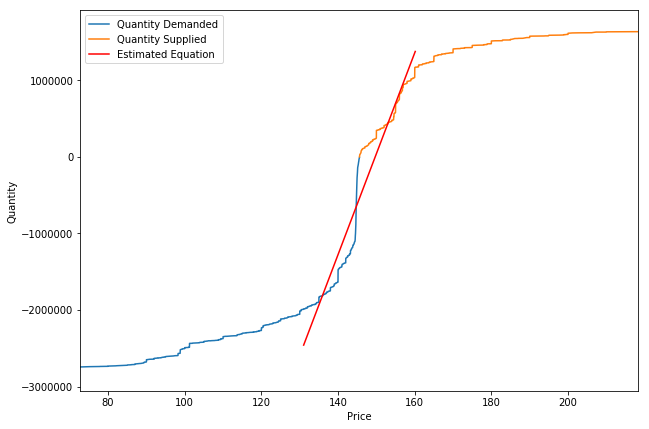

The estimated p_0 is: 149.686787
The actual midpoint of the BBO is: 145.580000


In [108]:
show_orderbook(file_objs[0], 50)

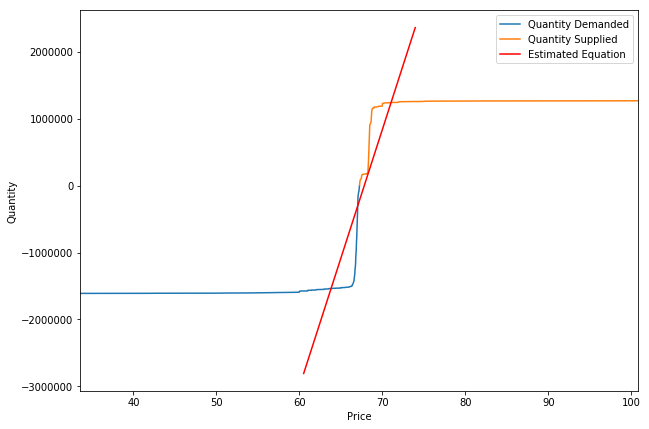

The estimated p_0 is: 67.818742
The actual midpoint of the BBO is: 67.240000


In [109]:
show_orderbook(file_objs[1], 100)

### Plot estimated value of $\frac{2\sigma_u}{\sqrt{\Sigma_0}}$  throughout the day

In [95]:
def plot_ratio(file_obj, title):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        ratio[ii] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(r'$\frac{2\sigma_u}{\sqrt{\Sigma_0}}$')
    plt.show()

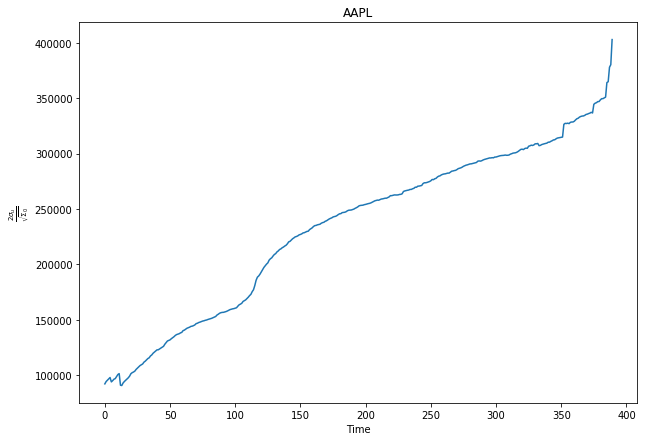

In [96]:
plot_ratio(file_objs[0], 'AAPL')

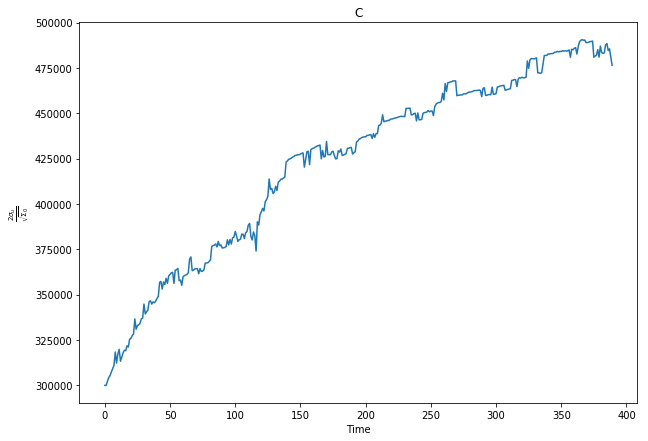

In [97]:
plot_ratio(file_objs[1], 'C')

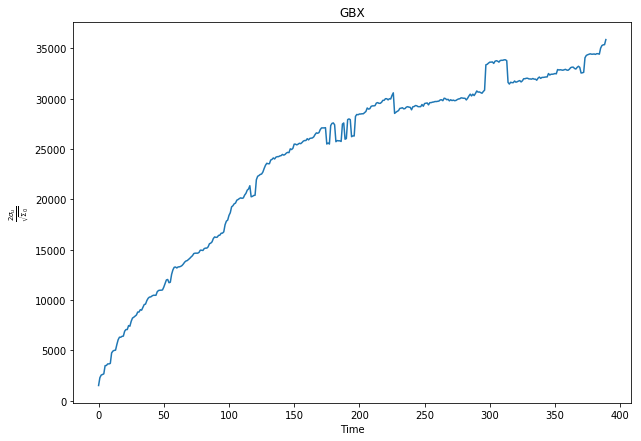

In [98]:
plot_ratio(file_objs[2], 'GBX')

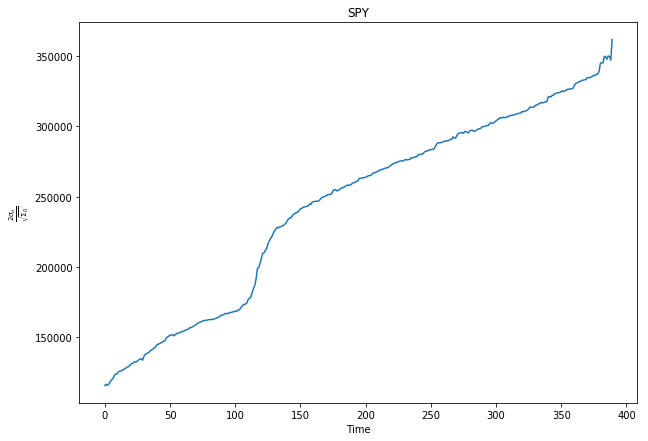

In [99]:
plot_ratio(file_objs[3], 'SPY')

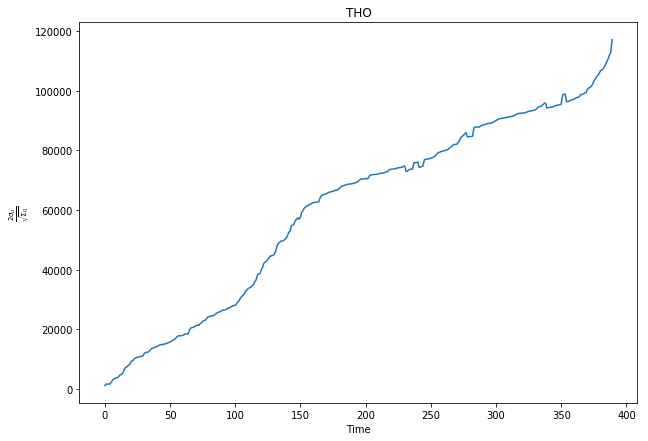

In [100]:
plot_ratio(file_objs[4], 'THO')

### Compare estimates of $p_0$ to the actual midpoint of the BBO over time

In [101]:
def compare_p(file_obj, title, cutval=1):
    p_est = np.zeros(len(file_obj), dtype=np.float64)
    p_act = np.zeros(len(file_obj), dtype=np.float64)
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        p_est[ii] = book.p
        p_act[ii] = book.midpoint
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(p_est - p_act, label=r'$\hat{p}_0 - p_0$')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'$p$')
    plt.show()

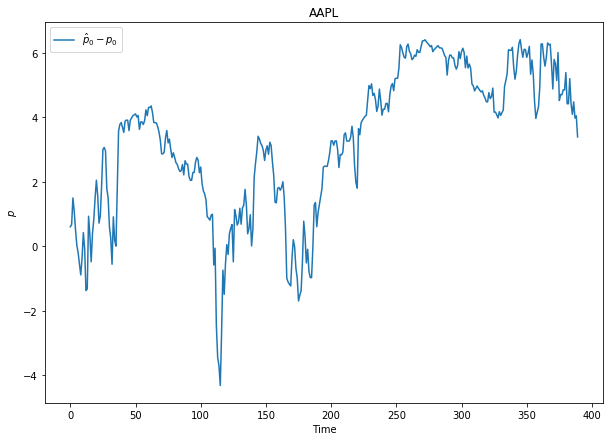

In [102]:
compare_p(file_objs[0], 'AAPL')

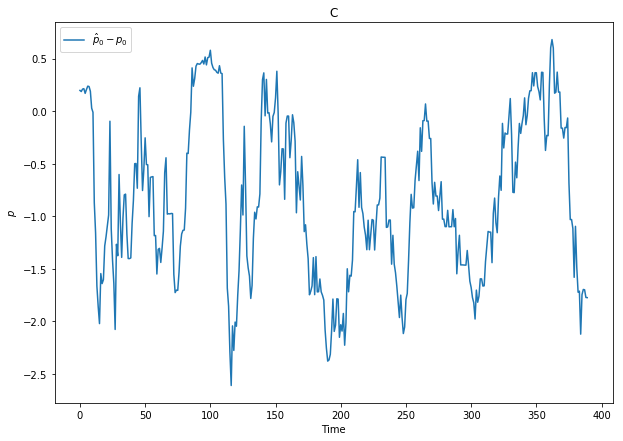

In [103]:
compare_p(file_objs[1], 'C')

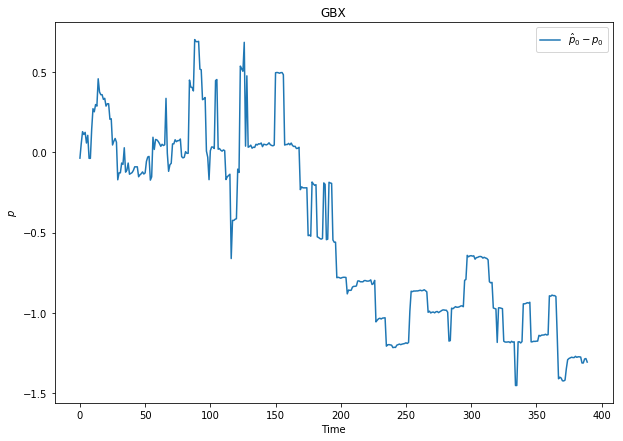

In [104]:
compare_p(file_objs[2], 'GBX')

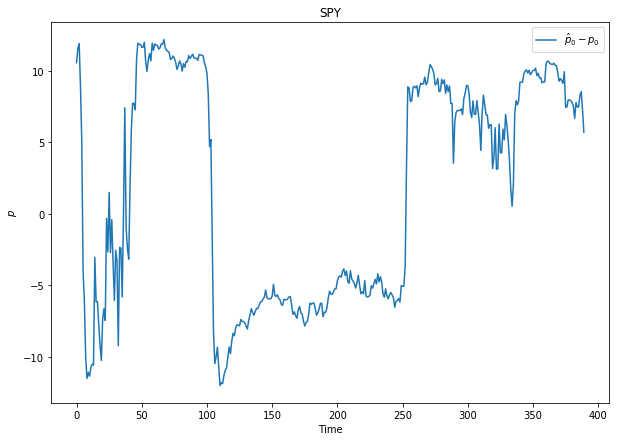

In [105]:
compare_p(file_objs[3], 'SPY')

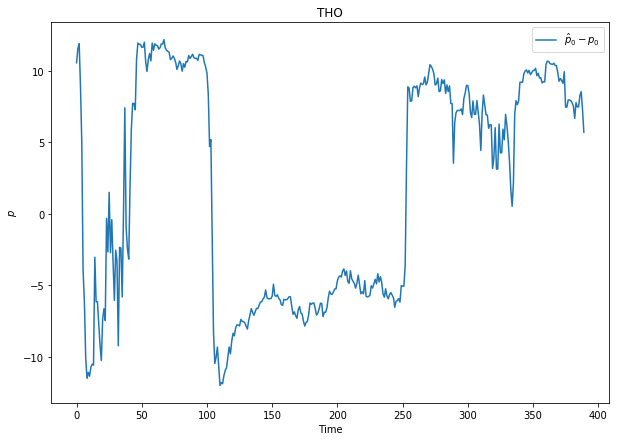

In [106]:
compare_p(file_objs[3], 'THO')